In [47]:
# Cell 1: Import and setup
import os
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import spearmanr, chi2_contingency, mannwhitneyu, kruskal
from collections import Counter
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_curve, roc_auc_score


# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [45]:
#cell 2 loading the datasets

gene_df = pd.read_csv(r"C:\Users\vnove\OneDrive\Documents\Maize\SEG_analysis\comprehensive_gene_analysis.csv")
pairwise_df = pd.read_csv(r"C:\Users\vnove\OneDrive\Documents\Maize\SEG_analysis\comprehensive_pairwise_analysis.csv")
corr_df = pd.read_csv(r"C:\Users\vnove\OneDrive\Documents\Maize\SEG_analysis\detailed_correlation_analysis.csv")
evol_strat_df = pd.read_csv(r"C:\Users\vnove\OneDrive\Documents\Maize\SEG_analysis\evolutionary_strategy_analysis.csv")
lcr_df = pd.read_csv(r"C:\Users\vnove\OneDrive\Documents\Maize\SEG_analysis\comprehensive_lcr_paralog_dataset.csv")

In [3]:
#checking pairwaise dataframe names
print(pairwise_df.columns.tolist())

['Gene1_ID', 'Gene2_ID', 'Gene1_Chromosome', 'Gene2_Chromosome', 'Same_Chromosome', 'Genomic_Distance_bp', 'Gene1_Start', 'Gene1_End', 'Gene2_Start', 'Gene2_End', 'Gene1_LCR_Relative_Start', 'Gene1_LCR_Relative_End', 'Gene1_LCR_Relative_Mid', 'Gene2_LCR_Relative_Start', 'Gene2_LCR_Relative_End', 'Gene2_LCR_Relative_Mid', 'Gene1_LCR_Genomic_Start', 'Gene1_LCR_Genomic_End', 'Gene2_LCR_Genomic_Start', 'Gene2_LCR_Genomic_End', 'Gene1_LCR_Length', 'Gene2_LCR_Length', 'Start_Position_Similarity', 'End_Position_Similarity', 'Mid_Position_Similarity', 'Overall_Position_Similarity', 'LCR_Length_Similarity', 'LCR_Count_Similarity', 'Physical_Overlap_bp', 'Is_Related_Formation', 'Distance_Category', 'Gene1_Length', 'Gene2_Length', 'Length_Ratio', 'Length_Difference', 'Position_Overlap_Category', 'Formation_Type']


**Question 1: Relative position of LCRs in Paralogs**

Goals: Distinguis whether LCRs in paralogs are similarly positioned or randomly positoned 


In [4]:
# 1a) Calculate absolute difference between LCR midpoints (relative to gene length)
pairwise_df['LCR_Position_Diff'] = abs(
    pairwise_df['Gene1_LCR_Relative_Mid'] - pairwise_df['Gene2_LCR_Relative_Mid']
)

# Set threshold: define what counts as "similar position"
threshold = pairwise_df['LCR_Position_Diff'].quantile(0.49) #Determines the cutoff between related or independent formation (This cutoff is based on the 0.80 youden threshold)

print(f"Data-driven position similarity threshold: {threshold:.2f}")

# Flag pairs as positionally similar if below threshold
pairwise_df['LCR_Position_Similar'] = pairwise_df['LCR_Position_Diff'] <= threshold

# Create summary table: % of similar vs not-similar by Formation_Type
position_overlap_summary = (
    pairwise_df.groupby('Formation_Type')['LCR_Position_Similar']
    .value_counts(normalize=True)
    .unstack()
)

# Display the summary
position_overlap_summary


Data-driven position similarity threshold: 0.20


LCR_Position_Similar,False,True
Formation_Type,,
Independent_Formation,1.000000,NaN
Mixed_Formation,0.988196,0.011804
Related_Formation,NaN,1.000000


In [5]:
#1b) Formation stats
pairwise_df[pairwise_df['Formation_Type'] == 'Mixed_Formation']['LCR_Position_Diff'].describe()


count    1186.000000
mean        0.379055
std         0.142093
min         0.200087
25%         0.258581
50%         0.345468
75%         0.487956
max         0.698287
Name: LCR_Position_Diff, dtype: float64

In [6]:
#1c) Formation stats
pairwise_df.groupby('Formation_Type')['LCR_Position_Similar'].value_counts()


Formation_Type         LCR_Position_Similar
Independent_Formation  False                    698
Mixed_Formation        False                   1172
                       True                      14
Related_Formation      True                    1782
Name: count, dtype: int64

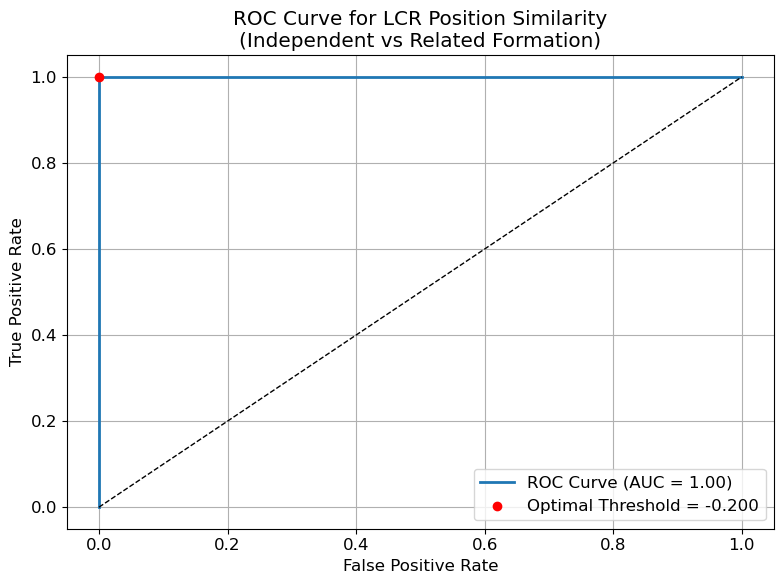

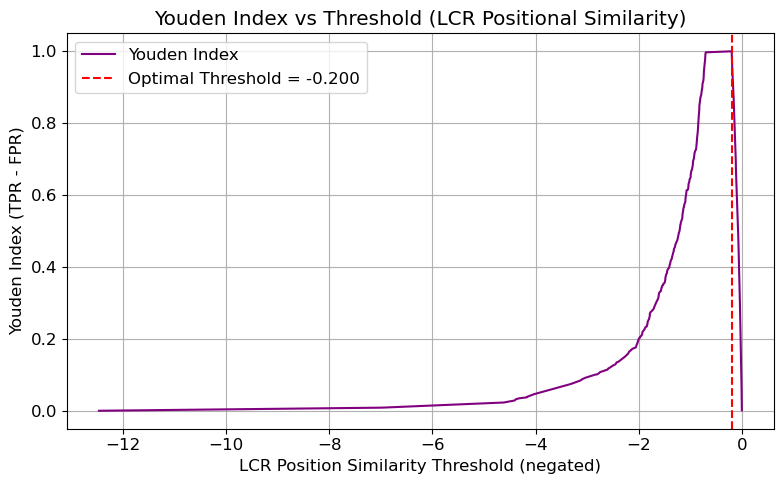

In [7]:
#1d)Youden Index for quantile percentage cutoff in 1a
# Assign binary class: Independent (0), Related (1)
pairwise_df['Binary_Class'] = pairwise_df['Formation_Type'].map({
    'Independent_Formation': 0,
    'Related_Formation': 1
})

# Drop missing values
roc_data = pairwise_df.dropna(subset=['Binary_Class', 'LCR_Position_Diff'])

# Compute ROC curve: use negative because lower LCR_Position_Diff = more similarity
fpr, tpr, thresholds = roc_curve(roc_data['Binary_Class'], -roc_data['LCR_Position_Diff'])

# Compute Youden Index
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
auc_score = roc_auc_score(roc_data['Binary_Class'], -roc_data['LCR_Position_Diff'])

# === Plot ROC curve with Youden Index ===
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', lw=2)
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}', zorder=5)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curve for LCR Position Similarity\n(Independent vs Related Formation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Youden Index across thresholds ===
plt.figure(figsize=(8,5))
plt.plot(thresholds, youden_index, label='Youden Index', color='purple')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.title("Youden Index vs Threshold (LCR Positional Similarity)")
plt.xlabel("LCR Position Similarity Threshold (negated)")
plt.ylabel("Youden Index (TPR - FPR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
#1e) Converting above value to quantile form
quantile_value = (pairwise_df['LCR_Position_Diff'] <= 0.20).mean()
print(f"Proportion of values ≤ 0.20: {quantile_value:.2f}")


Proportion of values ≤ 0.20: 0.49


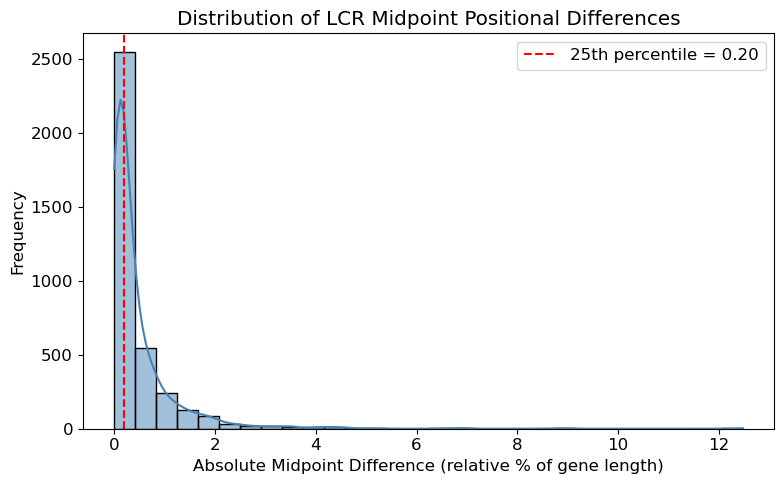

In [9]:
#1f) LCR Position Similarity histogram + KDE 
plt.figure(figsize=(8, 5))
sns.histplot(pairwise_df['LCR_Position_Diff'].dropna(), bins=30, kde=True, color='steelblue')
plt.axvline(threshold, color='red', linestyle='--', label=f"25th percentile = {threshold:.2f}")
plt.title("Distribution of LCR Midpoint Positional Differences")
plt.xlabel("Absolute Midpoint Difference (relative % of gene length)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

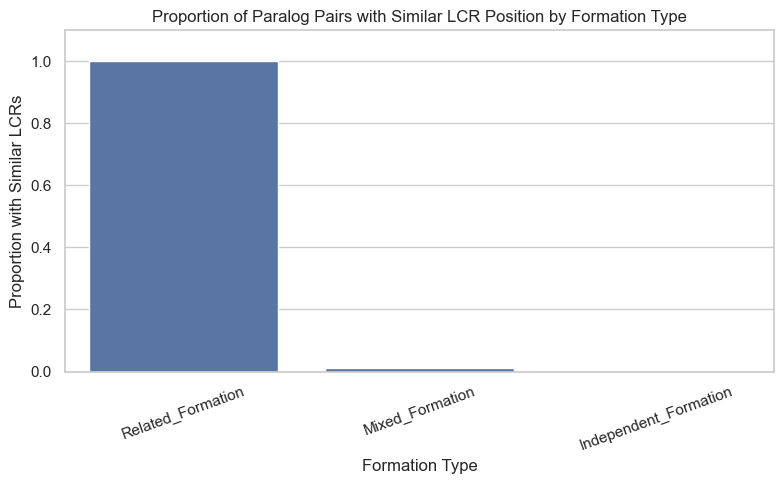

LCR_Position_Similar   False  True 
Formation_Type                     
Independent_Formation    698      0
Mixed_Formation         1172     14
Related_Formation          0   1782


In [10]:
#1g) Barplot of LCR Positional Similairty table
plot_df = pairwise_df[['Formation_Type', 'LCR_Position_Similar']].dropna()

sns.set(style="whitegrid")
plt.figure(figsize =(8,5))
sns.barplot(
    data=plot_df,
    x='Formation_Type',
    y='LCR_Position_Similar',
    estimator=lambda x: sum(x) / len(x),
    errorbar=None
)
plt.title('Proportion of Paralog Pairs with Similar LCR Position by Formation Type')
plt.ylabel('Proportion with Similar LCRs')
plt.xlabel('Formation Type')
plt.ylim(0.0, 1.1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Contingency table
contingency_counts = pd.crosstab(pairwise_df['Formation_Type'], pairwise_df['LCR_Position_Similar'])
print(contingency_counts)

In [11]:
#1h) Chi-Square Test for association between Duplication Type and LCR Positional Similarity

contingency = pd.crosstab(pairwise_df['Formation_Type'], pairwise_df['LCR_Position_Similar'])

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square test:")
print(f"p-value: {p:.4g}")
print(f"Chi2 statistics: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")

Chi-square test:
p-value: 0
Chi2 statistics: 3610.6385
Degrees of freedom: 2


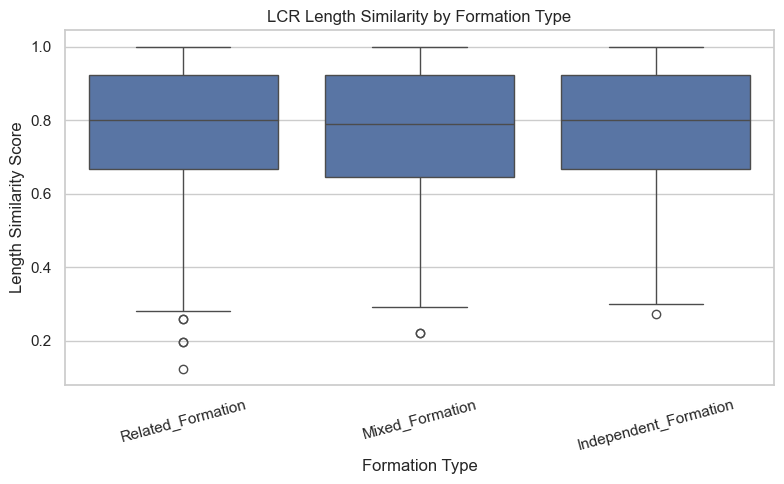

Kruskal-Wallis Test on LCR_Length_Similarity:
Statistic: 5.1699, p-value: 0.0754


In [12]:
#1i) Box plot and Kruskal-Wallis test for lcr length similarity

plt.figure(figsize=(8, 5))
sns.boxplot(data=pairwise_df, x='Formation_Type', y='LCR_Length_Similarity')
plt.title("LCR Length Similarity by Formation Type")
plt.ylabel("Length Similarity Score")
plt.xlabel("Formation Type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Kruskal-Wallis test again (length similarity may not be normally distributed)
groups = [group['LCR_Length_Similarity'].dropna() for name, group in pairwise_df.groupby('Formation_Type')]
stat, p = kruskal(*groups)

print("Kruskal-Wallis Test on LCR_Length_Similarity:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4g}")


**Data Analysis**

From the data above, using lcr similarity score (Which ranges from 0 - 1, with 1 being a perfect alignment) was used to test whether paralog formation was independent of eachother. There are three formation category, which are broken into: 
- Independent = 2.9 or less
- Mixed = 0.3 - 0.79
- Related = 0.79 or higher

Based on the data and statistics, the classification of which paralogs are independent or related to one another can be utilized.

I tried to use the LCR length similarity as another basis to determine paralog formation, however it was not a statistically significant variable to use to determine paralog formation as seen in 1i. 

**Question 2: Genetic Distance of Genes with vs Without LCRs**

Goal: Compare genetic distances to infer if LCR-containing genes evolve at different rates

ValueError: Could not interpret value `Has_LCR` for `x`. An entry with this name does not appear in `data`.

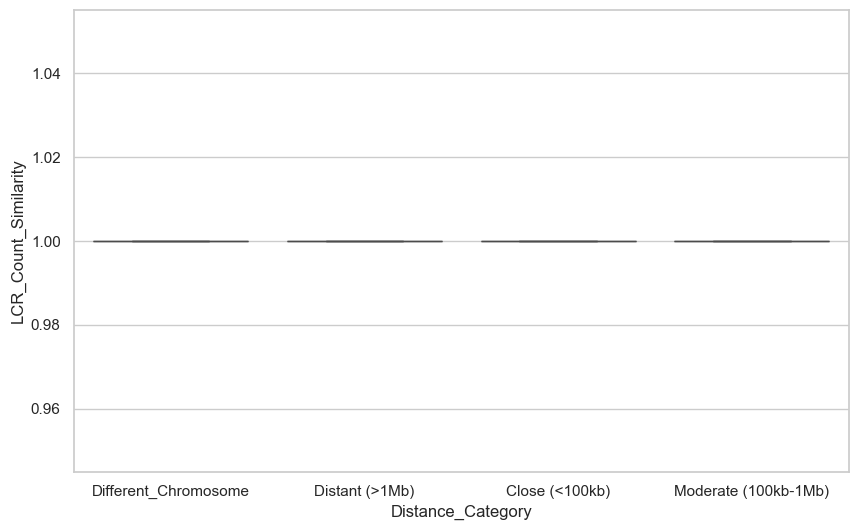

In [13]:
# Compare Length_Difference between pairs with and without LCRs
sns.boxplot(data=pairwise_df, x='Distance_Category', y='LCR_Count_Similarity')


sns.boxplot(data=pairwise_df, x='Has_LCR', y='Length_Difference')
plt.title("Gene Length Difference Between Pairs With vs Without LCRs")
plt.ylabel("Length Difference")
plt.xlabel("Has LCR")
plt.tight_layout()
plt.show()
pairwise_df['Has_LCR'] = (
    (pairwise_df['Gene1_LCR_Length'] > 0) | (pairwise_df['Gene2_LCR_Length'] > 0)
)
with_lcr = pairwise_df[pairwise_df['Has_LCR']]['Length_Difference'].dropna()
without_lcr = pairwise_df[~pairwise_df['Has_LCR']]['Length_Difference'].dropna()

stat, p = ttest_ind(with_lcr, without_lcr, equal_var=False)
print(f"T-test: stat = {stat:.3f}, p = {p:.4g}")

In [ ]:
#scatter plot of lcr length v genetic distance 
pairwise_df['Total_LCR_Length'] = pairwise_df['Gene1_LCR_Length'] + pairwise_df['Gene2_LCR_Length']


sns.scatterplot(data=pairwise_df, x='Total_LCR_Length', y='genetic_distance', alpha=0.5)
plt.title("Genetic Distance vs Total LCR Length")
plt.xlabel("Total LCR Length")
plt.ylabel("Genetic Distance")
plt.tight_layout()
plt.show()


In [ ]:
#Boxplot and T-test of gene length difference (W v W/O)
pairwise_df['Has_LCR'] = (pairwise_df['Gene1_LCR_Length'] > 0) | (pairwise_df['Gene2_LCR_Length'] > 0)

#Boxplot length difference by LCR Presence
plt.figure(figsize=(8, 5))
sns.boxplot(data=pairwise_df, x='Has_LCR', y='Length_Difference')
plt.title("Gene Length Difference in Pairs With vs Without LCRs")
plt.ylabel("Length Difference (bp)")
plt.xlabel("Has LCR")
plt.xticks([0, 1], ['No LCRs', 'Has LCR(s)'])
plt.tight_layout()
plt.show()

#LCR v No-LCR Length Difference Stats

with_lcr = pairwise_df[pairwise_df['Has_LCR']]['Length_Difference'].dropna()
without_lcr = pairwise_df[~pairwise_df['Has_LCR']]['Length_Difference'].dropna()

stat, p = ttest_ind(with_lcr, without_lcr, equal_var=False)
print(f"T-test result:")
print(f"Statistic: {stat:.3f}")
print(f"p-value: {p:.4g}")




**Question 3: Comparing Evolutionary DIstance Across Pairs With & With Out LCRs**

Goal: Testing whether recent duplicates differ in LCR evolutionary distance

In [14]:
#3a) Genetic distance score based on length and lcr dibergence 

# Normalize Length_Difference (z-score or min-max)
pairwise_df['Norm_Length_Diff'] = (pairwise_df['Length_Difference'] - pairwise_df['Length_Difference'].min()) / (pairwise_df['Length_Difference'].max() - pairwise_df['Length_Difference'].min())

# Invert similarity scores so higher = more divergent
pairwise_df['Divergence_LCR_Count'] = 1 - pairwise_df['LCR_Count_Similarity']
pairwise_df['Divergence_Position'] = 1 - pairwise_df['Overall_Position_Similarity']

# Composite Genetic Distance Score (custom weights)
pairwise_df['Genetic_Distance_Score'] = (
    0.5 * pairwise_df['Norm_Length_Diff'] +
    0.25 * pairwise_df['Divergence_LCR_Count'] +
    0.25 * pairwise_df['Divergence_Position']
)


Text(0.5, 1.0, 'Genetic Distance Score by Distance Category')

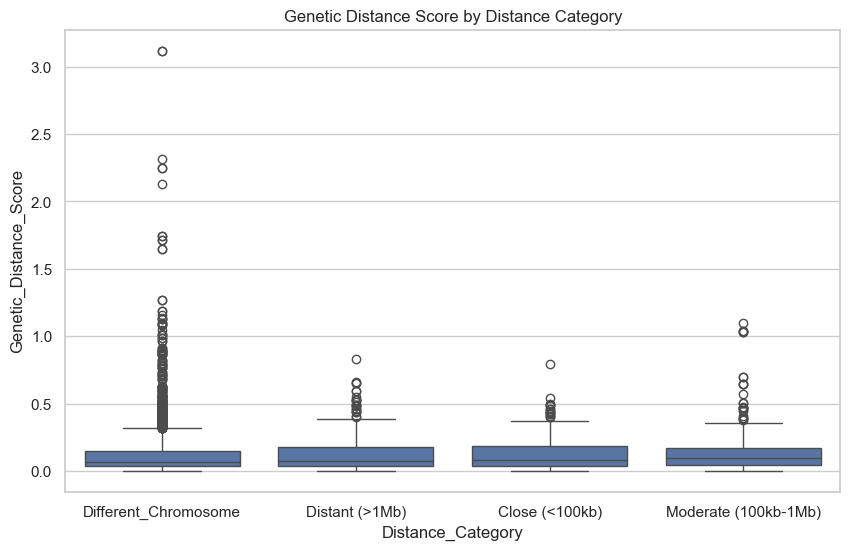

In [15]:
#3b) classification of recent dupes and boxplot of genetic divergence

pairwise_df['Recent_Dup'] = (pairwise_df['Same_Chromosome'] == 'Yes') & (pairwise_df['Genetic_Distance_Score'] < 0.3)
sns.boxplot(data=pairwise_df, x='Distance_Category', y='Genetic_Distance_Score')
plt.title("Genetic Distance Score by Distance Category")


In [16]:
#3c)  Gene and LCR divergence 

pairwise_df['genetic_distance'] = 1 - pairwise_df[
    ['Start_Position_Similarity', 'Mid_Position_Similarity', 'End_Position_Similarity']
].mean(axis=1)

pairwise_df['LCR_Distance'] = 1 - pairwise_df['LCR_Length_Similarity']

filtered_df = pairwise_df.dropna(subset=['genetic_distance', 'LCR_Distance'])

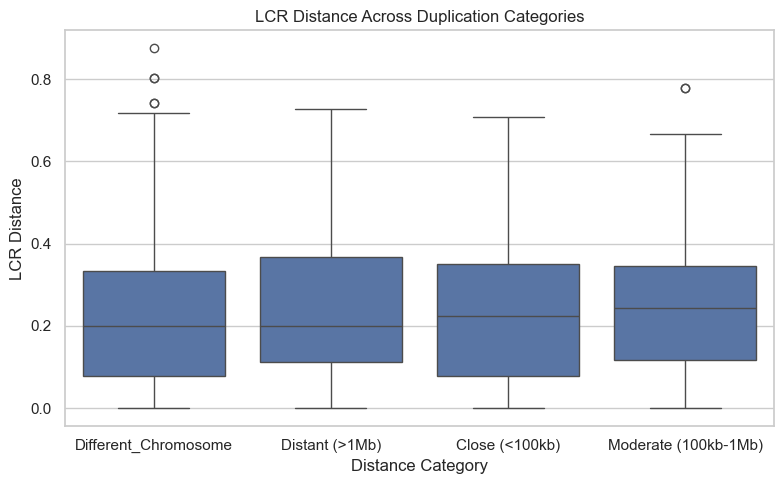

In [17]:
#3d) Boxplot of LCR divergence across duplication categories-
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_df, x='Distance_Category', y='LCR_Distance')
plt.title("LCR Distance Across Duplication Categories")
plt.xlabel("Distance Category")
plt.ylabel("LCR Distance")
plt.tight_layout()
plt.show()

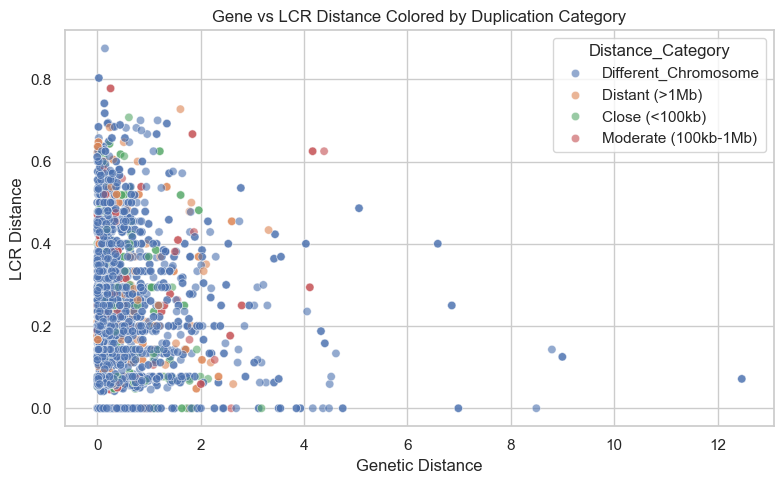

In [18]:
#3e)  Scatterplot of gene vs LCR divergence colored by duplication category 
plt.figure(figsize=(8, 5))
sns.scatterplot(data=filtered_df, x='genetic_distance', y='LCR_Distance',
                hue='Distance_Category', alpha=0.6)
plt.title("Gene vs LCR Distance Colored by Duplication Category")
plt.xlabel("Genetic Distance")
plt.ylabel("LCR Distance")
plt.tight_layout()
plt.show()

In [19]:
#3f) T-test: Compare recent vs older duplications
recent = filtered_df[filtered_df['Distance_Category'] == 'Close (<100kb)']['LCR_Distance']
older = filtered_df[filtered_df['Distance_Category'] != 'Close (<100kb)']['LCR_Distance']
stat, p = ttest_ind(recent, older, equal_var=False)

print(f"T-test: stat = {stat:.3f}, p = {p:.4g}")

T-test: stat = 0.430, p = 0.6672


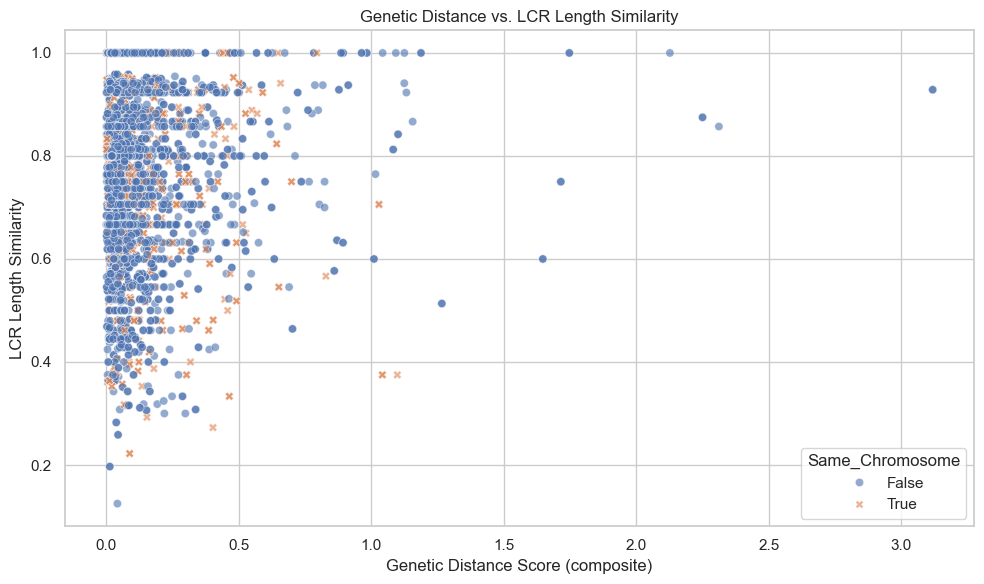

In [20]:
#3g) Scatter plot of genetic distance v. lcr length

sns.scatterplot(
    data=pairwise_df,
    x='Genetic_Distance_Score',
    y='LCR_Length_Similarity',
    hue='Same_Chromosome',
    alpha=0.6,
    style='Same_Chromosome'
)
plt.title("Genetic Distance vs. LCR Length Similarity")
plt.xlabel("Genetic Distance Score (composite)")
plt.ylabel("LCR Length Similarity")
plt.tight_layout()
plt.show()


In [23]:
#3h) Dimensionality reduction of gene divergence and lcr similarity

features = [
    'Length_Difference',
    'LCR_Count_Similarity',
    'LCR_Length_Similarity',
    'Overall_Position_Similarity',
    'Start_Position_Similarity',
    'Mid_Position_Similarity',
    'End_Position_Similarity'
]

# Drop rows with missing values in these features
filtered = pairwise_df.dropna(subset=features).copy()

# Normalize all features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(filtered[features])

# PCA (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
filtered['PCA1'] = pca_result[:, 0]
filtered['PCA2'] = pca_result[:, 1]

# UMAP (2 components)
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(X_scaled)
filtered['UMAP1'] = umap_result[:, 0]
filtered['UMAP2'] = umap_result[:, 1]


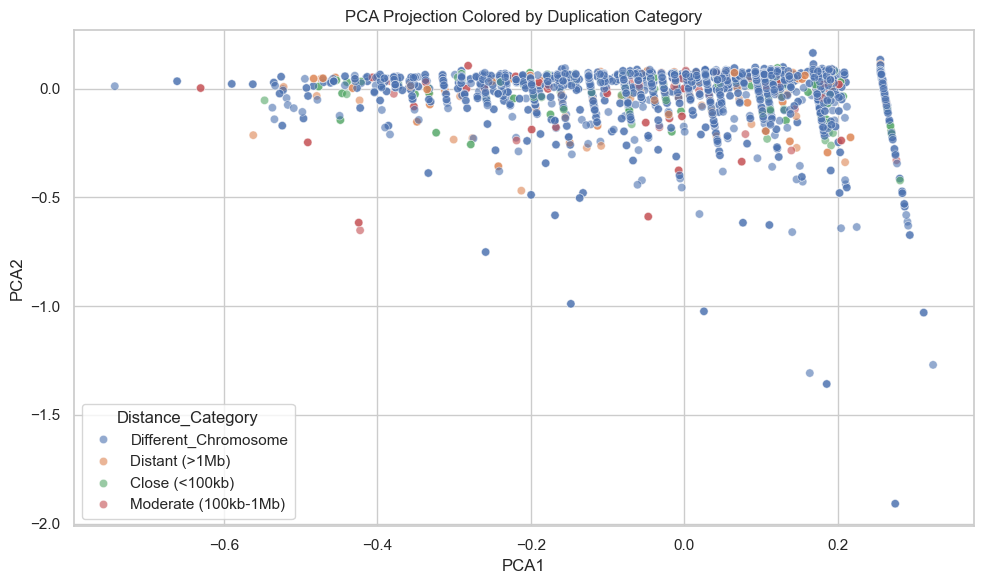

Explained Variance Ratio (PCA): [0.64038916 0.28972579]


In [24]:
#3i) PCA plot
sns.scatterplot(data=filtered, x='PCA1', y='PCA2', hue='Distance_Category', alpha=0.6)
plt.title("PCA Projection Colored by Duplication Category")
plt.tight_layout()
plt.show()
print("Explained Variance Ratio (PCA):", pca.explained_variance_ratio_)

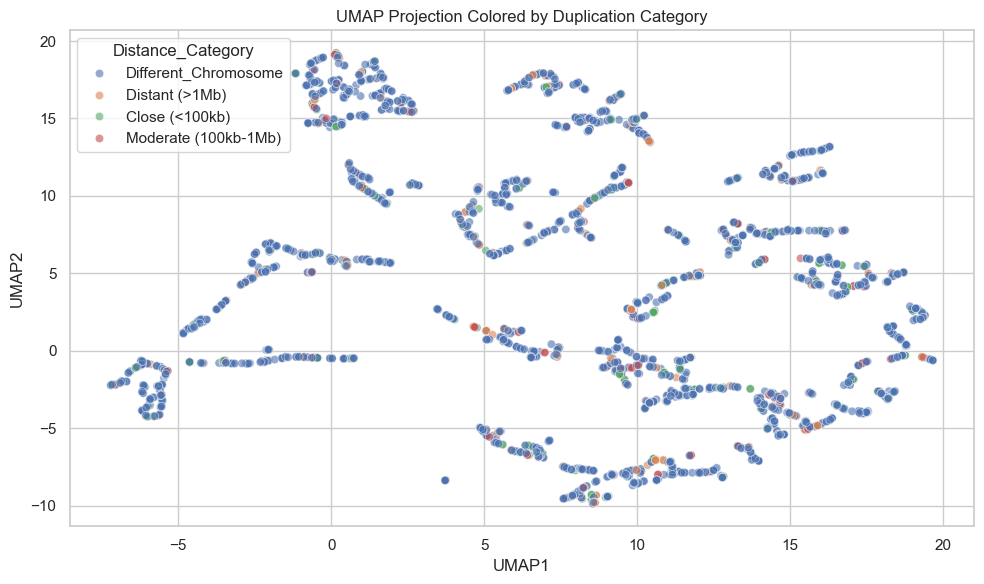

In [25]:
#3j) UMAP plot
sns.scatterplot(data=filtered, x='UMAP1', y='UMAP2', hue='Distance_Category', alpha=0.6)
plt.title("UMAP Projection Colored by Duplication Category")
plt.tight_layout()
plt.show()


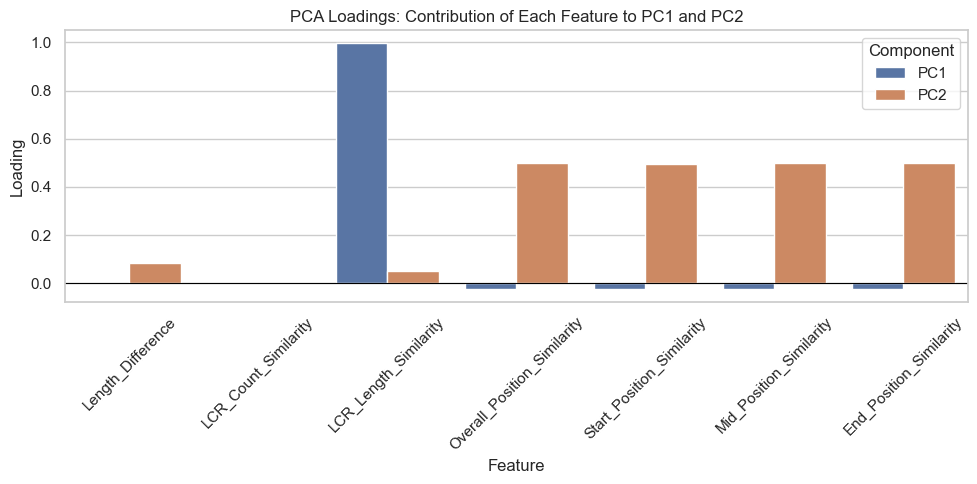

In [26]:
#3k) columns that contribute to PCA segregation 
pca_loadings = pd.DataFrame(
    data=pca.components_.T,
    index=features,
    columns=['PC1', 'PC2']
).reset_index().rename(columns={'index': 'Feature'})

plt.figure(figsize=(10, 5))
sns.barplot(data=pca_loadings.melt(id_vars="Feature", var_name="Component", value_name="Loading"),
            x="Feature", y="Loading", hue="Component")
plt.title("PCA Loadings: Contribution of Each Feature to PC1 and PC2")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [27]:
#3XX)
from scipy.stats import kruskal
groups = [group['Genetic_Distance_Score'].dropna() for name, group in pairwise_df.groupby('Distance_Category')]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis: Statistic = {stat:.4f}, p = {p:.4g}")

Kruskal-Wallis: Statistic = 13.8060, p = 0.003181


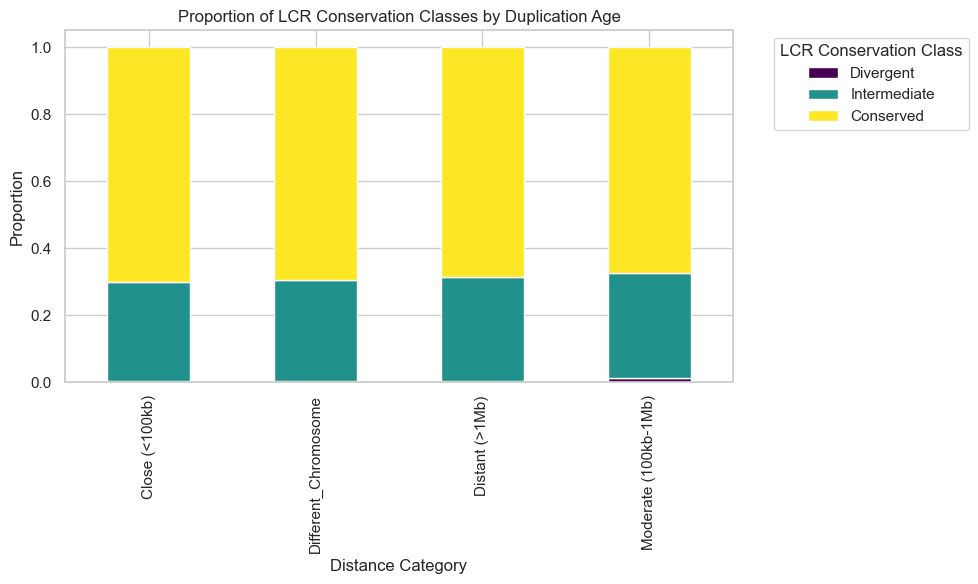

Contingency Table:
 LCR_Conservation_Class  Divergent  Intermediate  Conserved
Distance_Category                                         
Close (<100kb)                  1            77        184
Different_Chromosome            9           901       2069
Distant (>1Mb)                  1            84        186
Moderate (100kb-1Mb)            2            48        104

Chi-square test:
Chi2 statistic = 4.3921
Degrees of freedom = 6
P-value = 0.6238

Expected counts under the null hypothesis:
 LCR_Conservation_Class  Divergent  Intermediate    Conserved
Distance_Category                                           
Close (<100kb)           0.929078     79.328969   181.741953
Different_Chromosome    10.563830    901.988543  2066.447627
Distant (>1Mb)           0.960993     82.054010   187.984997
Moderate (100kb-1Mb)     0.546099     46.628478   106.825423


In [32]:
#3l)  Categorization of LCR levels based on similatiry scores
filtered['LCR_Conservation_Class'] = pd.cut(
    filtered['LCR_Length_Similarity'],
    bins=[-0.01, 0.3, 0.7, 1.01],
    labels=["Divergent", "Intermediate", "Conserved"]
)
# Count the number of LCR conservation classes within each Distance Category
conservation_counts = filtered.groupby(['Distance_Category', 'LCR_Conservation_Class']).size().unstack()

# Normalize to get proportions
conservation_props = conservation_counts.div(conservation_counts.sum(axis=1), axis=0)

# Plot the stacked bar chart
conservation_props.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Proportion of LCR Conservation Classes by Duplication Age")
plt.xlabel("Distance Category")
plt.ylabel("Proportion")
plt.legend(title="LCR Conservation Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Create the contingency table (same categories as in the barplot)
contingency_table = pd.crosstab(filtered['Distance_Category'], filtered['LCR_Conservation_Class'])

# Display the table
print("Contingency Table:\n", contingency_table)

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"\nChi-square test:")
print(f"Chi2 statistic = {chi2:.4f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p:.4g}")

# Optional: Display expected counts
print("\nExpected counts under the null hypothesis:\n", pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

Text(0.5, 1.0, 'LCR Length Divergence by Duplication Age')

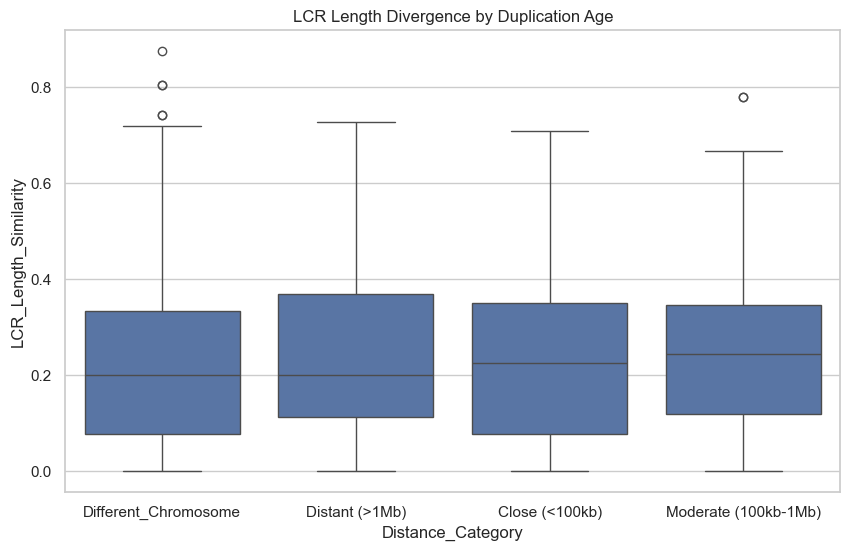

In [29]:
#3m) barplot of above cell
sns.boxplot(data=filtered, x='Distance_Category', y=1 - filtered['LCR_Length_Similarity'])
plt.title("LCR Length Divergence by Duplication Age")


Text(0.5, 1.0, 'Gene vs LCR Length Divergence')

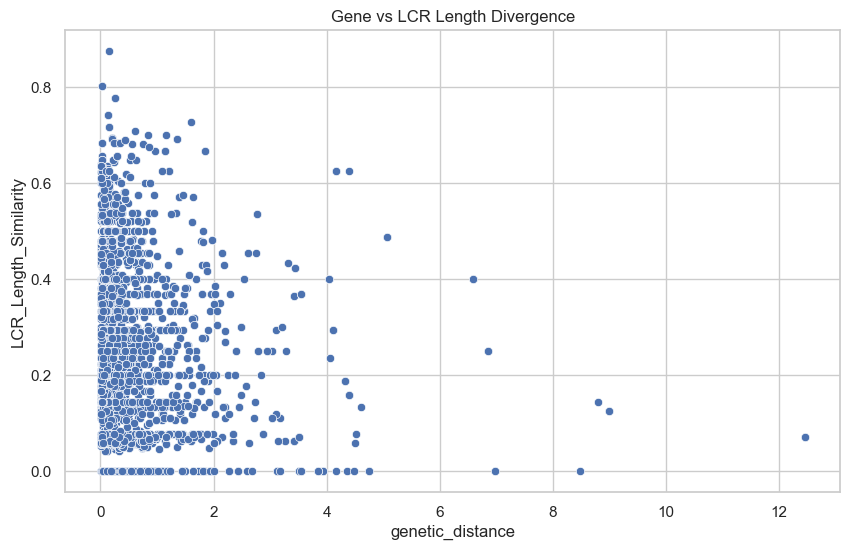

In [30]:
#3n) Scatterplot of Gene v LCR Length Divergence

sns.scatterplot(data=filtered, x='genetic_distance', y=1 - filtered['LCR_Length_Similarity'])
plt.title("Gene vs LCR Length Divergence")


From the data above we can see that there is a significant, and statistically significant, genetic divergence between recent and older duplications. However, no significant difference was observed in LCR divergence.

Cell 3b, further supported by the Kruskal-Wallis test (3XX), that older duplications contain higher genetic distance scores and more recent duplications and interestingly the genetic distance is even greater when the paralogs are on different chromosomes. However there is no significant difference between LCR similarity in recent and older duplications, this is highlighted with cell 3d and 3m. 

On the other hand, there was no statistically significant difference in LCR length similarit across duplication categories, as seen in cell 3d and 3m. Pointing at a possible stability in LCR evolution over time or less influenced by duplication age. To understand if there was a correlation between LCR and gene divergence (3n), we observed no high correlation. Paralogs with higher genetic distnces maintain similar LCR lengths compared to paralogs that have a lower gentic distance. LCR may follow different evolutionarly pressures than their surronding sequences.


**Secondary Paper Analysis**

In [33]:
#1S) Pearson correlation between LCR % and PAR count
r_value, p_value = pearsonr(gene_df['LCR_Count_Percentile'], gene_df['Paralog_Count_Percentile'])
print(f"Pearson correlation: r = {r_value:.3f}, p = {p_value:.3e}")

Pearson correlation: r = 0.042, p = 2.061e-03


                  count      mean       std  min       25%       50%  \
Same_Chromosome                                                        
False            2979.0  0.224135  0.163802  0.0  0.076923  0.200000   
True              687.0  0.240134  0.178119  0.0  0.081940  0.210526   

                      75%       max  
Same_Chromosome                      
False            0.333333  0.875000  
True             0.356818  0.777778  


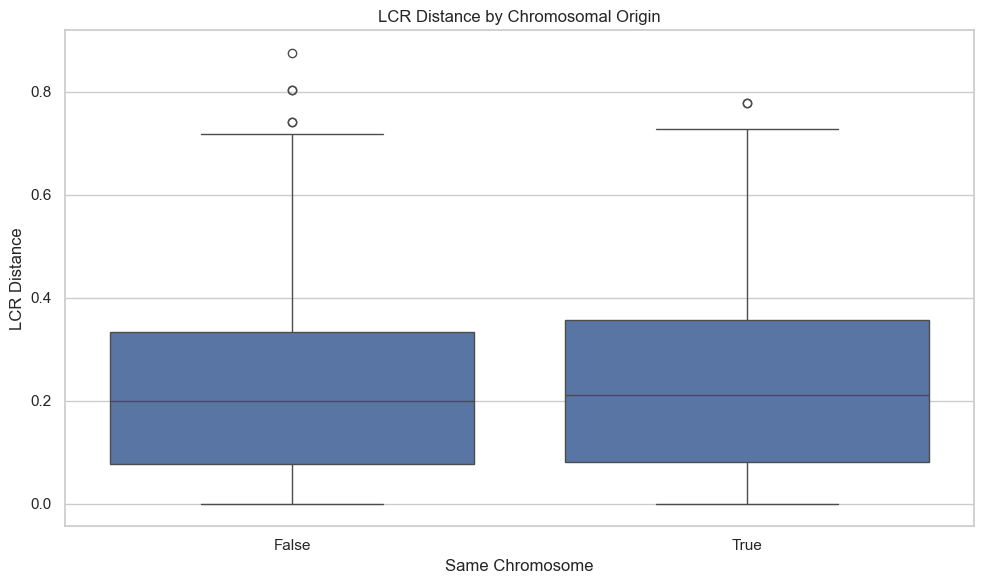

In [34]:
#2S) Comparison of LCRs of paralog pairs on the same chromosome

print(pairwise_df.groupby('Same_Chromosome')['LCR_Distance'].describe())

sns.boxplot(x='Same_Chromosome', y='LCR_Distance', data=pairwise_df)
plt.title('LCR Distance by Chromosomal Origin')
plt.xlabel('Same Chromosome')
plt.ylabel('LCR Distance')
plt.tight_layout()
plt.show()

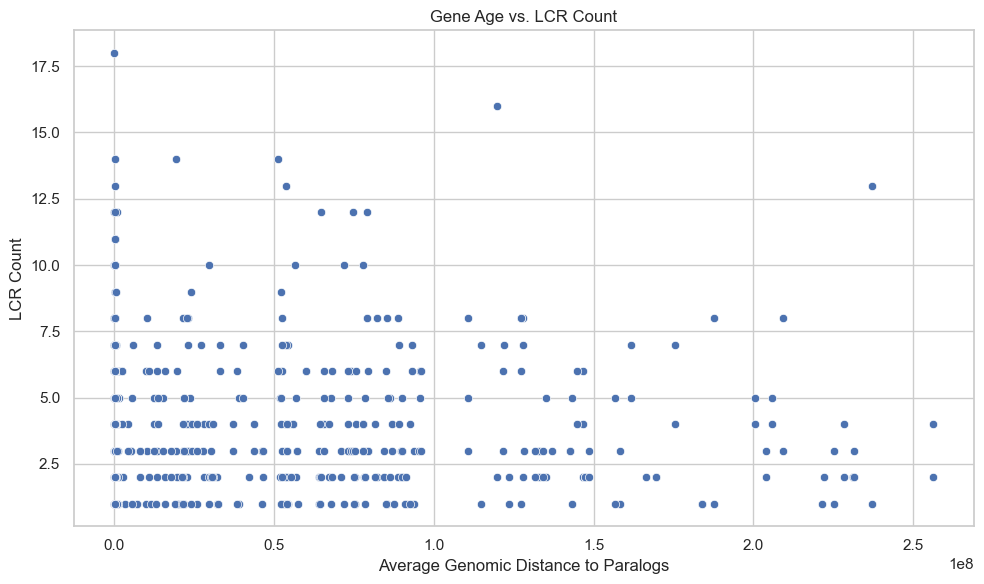

In [35]:
#3S) Gene v LCR count

sns.scatterplot(x='Avg_Genomic_Distance', y='LCR_Count', data=gene_df)
plt.title('Gene Age vs. LCR Count')
plt.xlabel('Average Genomic Distance to Paralogs')
plt.ylabel('LCR Count')
plt.tight_layout()
plt.show()

In [36]:
#4S)  One-way ANOVA: LCR_Count for Evolutionary_Strategy
anova_result = stats.f_oneway(*[group['LCR_Count'] for name, group in gene_df.groupby('Evolutionary_Strategy')])
print(f"ANOVA F = {anova_result.statistic:.3f}, p = {anova_result.pvalue:.3e}")


ANOVA F = 4273.864, p = 0.000e+00


In [37]:
print(evol_strat_df.columns.tolist())


['Evolutionary_Strategy', 'Gene_ID_count', 'LCR_Count_mean', 'LCR_Count_std', 'Total_Paralogs_mean', 'Total_Paralogs_std', 'Total_LCR_Length_mean', 'Total_LCR_Length_std', 'Same_Chr_Paralogs_mean', 'Same_Chr_Paralogs_std', 'Diff_Chr_Paralogs_mean', 'Diff_Chr_Paralogs_std']


In [38]:
#5S) Tukey's post-hoc test after ANOVA
tukey = pairwise_tukeyhsd(endog=gene_df['LCR_Count'],
                          groups=gene_df['Evolutionary_Strategy'],
                          alpha=0.05)
print(tukey)


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2        meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------
High_LCR_High_Paralogs High_LCR_Low_Paralogs  -0.1777 0.1028 -0.3757  0.0203  False
High_LCR_High_Paralogs Low_LCR_High_Paralogs  -5.4599    0.0 -5.5935 -5.3263   True
High_LCR_High_Paralogs  Low_LCR_Low_Paralogs  -5.5011    0.0 -5.6676 -5.3345   True
High_LCR_High_Paralogs               Unknown  -3.5246    0.0 -3.6587 -3.3904   True
 High_LCR_Low_Paralogs Low_LCR_High_Paralogs  -5.2822    0.0 -5.4734  -5.091   True
 High_LCR_Low_Paralogs  Low_LCR_Low_Paralogs  -5.3234    0.0 -5.5389 -5.1078   True
 High_LCR_Low_Paralogs               Unknown  -3.3469    0.0 -3.5385 -3.1552   True
 Low_LCR_High_Paralogs  Low_LCR_Low_Paralogs  -0.0412 0.9545 -0.1996  0.1172  False
 Low_LCR_High_Paralogs               Unknown   1.9353    0.0  1.8114  2.0592

In [39]:
#6S) Average correlation per subgroup
analysis_groups = corr_df['Analysis'].unique()
for analysis in analysis_groups:
    subset = corr_df[corr_df['Analysis'] == analysis]
    mean_corr = subset['Correlation'].mean()
    print(f"{analysis}: Mean Correlation = {mean_corr:.3f}")

Overall: Mean Correlation = 0.029
LCR_Category_Single_LCR: Mean Correlation = nan
LCR_Category_Few_LCRs: Mean Correlation = nan
LCR_Category_Many_LCRs: Mean Correlation = 0.025
Paralog_Diversity_Diff_Chr_Only: Mean Correlation = -0.021
Paralog_Diversity_Same_Chr_Only: Mean Correlation = 0.011
Paralog_Diversity_Mixed: Mean Correlation = -0.102


Global Spearman correlation between LCR count and total paralogs:
ρ = 0.042, p = 2.061e-03
Pearson r = 0.016, p = 2.495e-01


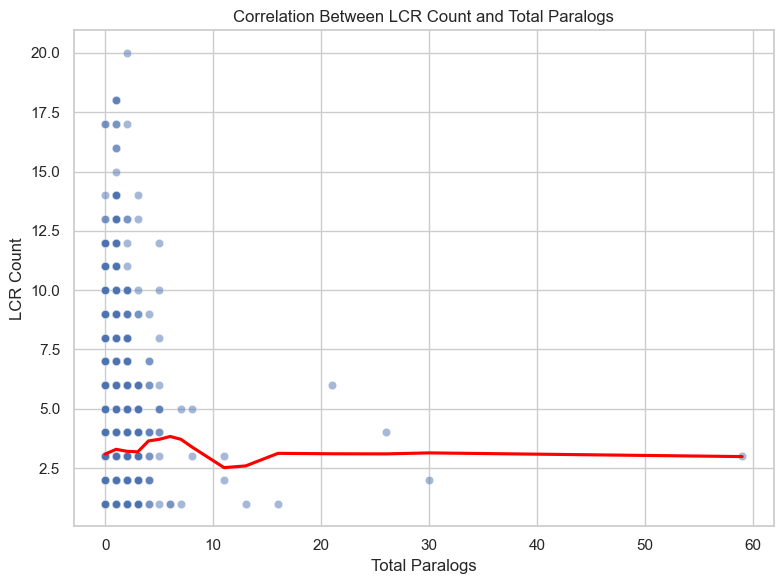


Spearman correlation by Evolutionary Strategy:
High_LCR_High_Paralogs: ρ = 0.019, p = 5.138e-01
High_LCR_Low_Paralogs: Skipped (not enough variation)
Low_LCR_High_Paralogs: ρ = -0.030, p = 2.255e-01
Low_LCR_Low_Paralogs: Skipped (not enough variation)
Unknown: ρ = 0.028, p = 2.734e-01


In [40]:
#7S) Correlation betweeb LCR # and Paralog # across genes and evolution

gene_df['log_paralogs'] = np.log1p(gene_df['Total_Paralogs'])
spearmanr(gene_df['log_paralogs'], gene_df['LCR_Count'])

# === Global Spearman Correlation ===
rho, pval = spearmanr(gene_df['LCR_Count'], gene_df['Total_Paralogs'])
print(f"Global Spearman correlation between LCR count and total paralogs:")
print(f"ρ = {rho:.3f}, p = {pval:.3e}")

# === Optional: Pearson correlation if relationship is linear ===
r_val, p_val_pearson = pearsonr(gene_df['LCR_Count'], gene_df['Total_Paralogs'])
print(f"Pearson r = {r_val:.3f}, p = {p_val_pearson:.3e}")

# === Scatterplot ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Total_Paralogs', y='LCR_Count', data=gene_df, alpha=0.5)
sns.regplot(x='Total_Paralogs', y='LCR_Count', data=gene_df, scatter=False, lowess=True, color='red')
plt.title("Correlation Between LCR Count and Total Paralogs")
plt.xlabel("Total Paralogs")
plt.ylabel("LCR Count")
plt.tight_layout()
plt.show()

# === Correlation by Evolutionary Strategy ===
print("\nSpearman correlation by Evolutionary Strategy:")
for strategy, group in gene_df.groupby('Evolutionary_Strategy'):
    if group['LCR_Count'].nunique() > 1 and group['Total_Paralogs'].nunique() > 1:
        rho, pval = spearmanr(group['LCR_Count'], group['Total_Paralogs'])
        print(f"{strategy}: ρ = {rho:.3f}, p = {pval:.3e}")
    else:
        print(f"{strategy}: Skipped (not enough variation)")

In [42]:
#8S) Collect and correct p-values
strategy_pvals = []
strategy_labels = []

for strategy, group in gene_df.groupby('Evolutionary_Strategy'):
    if group['LCR_Count'].nunique() > 1 and group['Total_Paralogs'].nunique() > 1:
        _, pval = spearmanr(group['LCR_Count'], group['Total_Paralogs'])
        strategy_pvals.append(pval)
        strategy_labels.append(strategy)

from statsmodels.stats.multitest import multipletests
_, bonf_pvals, _, _ = multipletests(strategy_pvals, method='bonferroni')

# Report
print("\nBonferroni-corrected p-values:")
for label, raw, adj in zip(strategy_labels, strategy_pvals, bonf_pvals):
    print(f"{label}: raw p = {raw:.4g}, adjusted p = {adj:.4g}")



Bonferroni-corrected p-values:
High_LCR_High_Paralogs: raw p = 0.5138, adjusted p = 1
Low_LCR_High_Paralogs: raw p = 0.2255, adjusted p = 0.6765
Unknown: raw p = 0.2734, adjusted p = 0.8203


In [61]:
def classify_lcr_type(seq):
    if len(set(seq)) == 1:
        return 'PolyX'
    elif re.search(r'(..+?)\1{2,}', seq):  # Tandem repeat pattern
        return 'Tandem'
    else:
        return 'Complex'

lcr_df['LCR_Type'] = lcr_df['LCR_Sequence'].apply(classify_lcr_type)


In [62]:
gene_lcr_type = (
    lcr_df.groupby('Gene_ID')['LCR_Type']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    .reset_index()
)


In [63]:
pairwise_df = pairwise_df.merge(
    gene_lcr_type.rename(columns={'Gene_ID': 'Gene1_ID', 'LCR_Type': 'Gene1_LCR_Type'}),
    on='Gene1_ID', how='left'
)
pairwise_df = pairwise_df.merge(
    gene_lcr_type.rename(columns={'Gene_ID': 'Gene2_ID', 'LCR_Type': 'Gene2_LCR_Type'}),
    on='Gene2_ID', how='left'
)


In [64]:
pairwise_df['LCR_Type_Relationship'] = pairwise_df.apply(
    lambda row: 'Same' if row['Gene1_LCR_Type'] == row['Gene2_LCR_Type'] else 'Different',
    axis=1
)

# Optional preview
print(pairwise_df[['Gene1_ID', 'Gene2_ID', 'Gene1_LCR_Type', 'Gene2_LCR_Type', 'LCR_Type_Relationship']].head())


              Gene1_ID             Gene2_ID Gene1_LCR_Type Gene2_LCR_Type  \
0  Zm00001d000006_T001  Zm00001d025059_T001         Tandem         Tandem   
1  Zm00001d000012_T001  Zm00001d025059_T001        Complex         Tandem   
2  Zm00001d000017_T001  Zm00001d025059_T001         Tandem         Tandem   
3  Zm00001d000018_T001  Zm00001d025059_T001         Tandem         Tandem   
4  Zm00001d000027_T028  Zm00001d025455_T001        Complex         Tandem   

  LCR_Type_Relationship  
0                  Same  
1             Different  
2                  Same  
3                  Same  
4             Different  


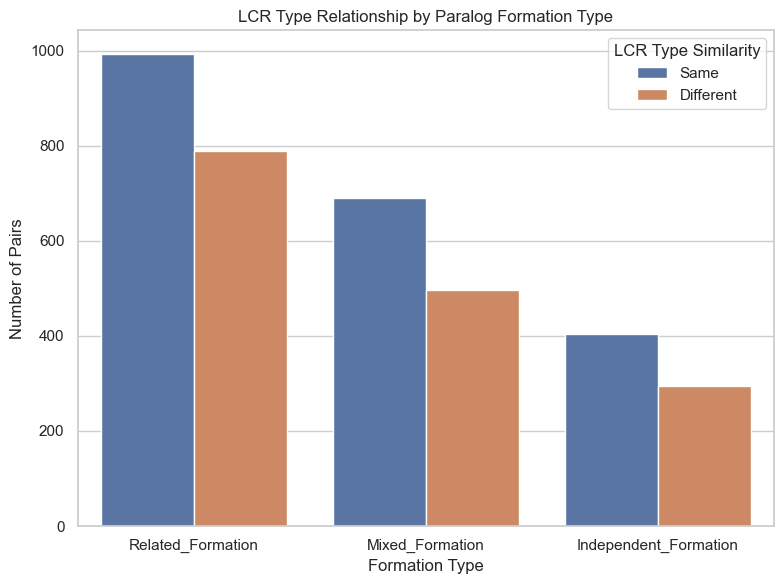

Chi-square test results:
Chi2 statistic = 2.00
p-value = 3.6880e-01
Degrees of freedom = 2

Expected frequencies:
LCR_Type_Relationship   Different         Same
Formation_Type                                
Independent_Formation  300.829242   397.170758
Mixed_Formation        511.151118   674.848882
Related_Formation      768.019640  1013.980360
LCR_Type_Relationship                        Different      Same
Formation_Type        Formation_Type                            
Independent_Formation Independent_Formation   0.422636  0.577364
Mixed_Formation       Mixed_Formation         0.418212  0.581788
Related_Formation     Related_Formation       0.442761  0.557239


In [65]:

plt.figure(figsize=(8, 6))
sns.countplot(data=pairwise_df, x='Formation_Type', hue='LCR_Type_Relationship')
plt.title("LCR Type Relationship by Paralog Formation Type")
plt.ylabel("Number of Pairs")
plt.xlabel("Formation Type")
plt.legend(title="LCR Type Similarity")
plt.tight_layout()
plt.show()


# Create contingency table
contingency = pd.crosstab(pairwise_df['Formation_Type'], pairwise_df['LCR_Type_Relationship'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

# Report
print("Chi-square test results:")
print(f"Chi2 statistic = {chi2:.2f}")
print(f"p-value = {p:.4e}")
print(f"Degrees of freedom = {dof}")
print("\nExpected frequencies:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))

summary = (
    pairwise_df.groupby(['Formation_Type', 'LCR_Type_Relationship'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

print(summary)


From the data above we can see that, in contrast to the strong anticorrelation that was observed in the Persi et.al. 2023 article, maize displays a mutually exclusive use of LCRs and paralogs. Additionaly, from the spearman and pearson correlation test, we see a small and positive correlation between paralogs and LCRS. There is possibly a greater layer of complexity in the maize genome compared to the bacteria genome, which would be expected.

Another interesting finding is that some subgroups show negative correlation, however this is not statsitically significant. 